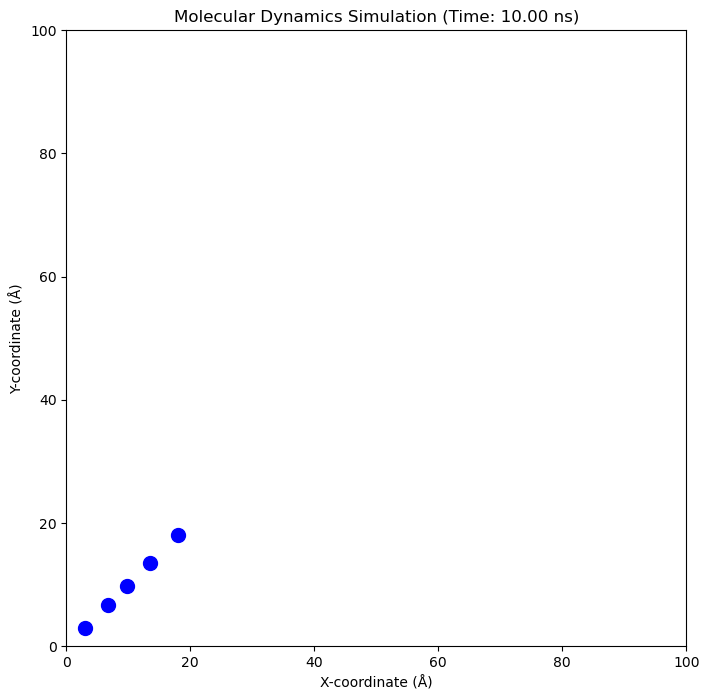

In [6]:
from __future__ import annotations
import numpy as np
from typing import List, Tuple, Optional, Set, Dict
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Atom:
    """Class representing an individual atom in the simulation."""
    def __init__(
        self, 
        position: Tuple[float, float, float], 
        velocity: Tuple[float, float, float], 
        mass: float, 
        epsilon: float, 
        sigma: float
    ) -> None:
        self.position: np.ndarray = np.array(position, dtype=float)
        self.velocity: np.ndarray = np.array(velocity, dtype=float)
        self.mass: float = mass
        self.epsilon: float = epsilon
        self.sigma: float = sigma
        self.force: np.ndarray = np.zeros(3, dtype=float)


class Potential(ABC):
    """Abstract base class for different potentials."""
    def __init__(self, 
                 pairwise_interactions: Optional[Set[Tuple[int, int]]] = None) -> None:
        self.pairwise_interactions = pairwise_interactions

    @abstractmethod
    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        pass


class Constraint(ABC):
    """Abstract base class for constraints."""
    @abstractmethod
    def apply(self, atoms: List[Atom], box_size: float) -> None:
        """Directly modify atoms to enforce constraints."""
        pass

class FixedDistanceConstraint(Constraint):
    """A constraint that fixes certain atom pairs at a given distance r0."""
    def __init__(
        self, 
        fixed_distances: Dict[Tuple[int, int], float], 
        pairwise_interactions: Optional[Set[Tuple[int,int]]] = None
    ) -> None:
        """
        fixed_distances: {(i,j): r0} 表示原子对 (i,j) 的目标距离为 r0。
                         通常建议也指定 (j,i) 使约束对称。
        pairwise_interactions: 如果给定，只对这些对应用该约束。
        """
        self.fixed_distances = fixed_distances
        self.pairwise_interactions = pairwise_interactions

    def apply(self, atoms: List[Atom], box_size: float) -> None:
        num_atoms = len(atoms)
        for i in range(num_atoms):
            for j in range(num_atoms):
                if i == j:
                    continue
                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue
                if (i, j) not in self.fixed_distances:
                    continue

                atom_i = atoms[i]
                atom_j = atoms[j]

                delta = atom_i.position - atom_j.position
                # 最小镜像原则（如果需要周期性边界条件）
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                r0 = self.fixed_distances[(i, j)]

                if r == 0:
                    # 如果两点重合，直接将其中一个点随机偏移一点，
                    # 或者按照自己需要的逻辑处理。
                    continue

                # 如果 r != r0，则进行位置调整
                if r != r0:
                    excess = r - r0
                    direction = delta / r
                    # 假设等量分配修正
                    correction = direction * (excess / 2.0)

                    # 调整原子位置，使得最终距离变回r0
                    atom_i.position -= correction
                    atom_j.position += correction

                    # 应用周期性边界条件修正后的坐标
                    atom_i.position %= box_size
                    atom_j.position %= box_size

class MaxDistanceConstraint(Constraint):
    """A constraint that ensures certain atom pairs do not exceed a specified max distance."""
    def __init__(self, 
                 max_distances: Dict[Tuple[int, int], float], 
                 pairwise_interactions: Optional[Set[Tuple[int,int]]] = None) -> None:
        """
        max_distances: {(i,j): d_max} 指定原子对 (i,j) 的最大距离，
                       通常希望 (j,i) 也同时指定以保持对称。
        
        pairwise_interactions: 如果指定，只对这些特定对进行检查。
        """
        self.max_distances = max_distances
        self.pairwise_interactions = pairwise_interactions

    def apply(self, atoms: List[Atom], box_size: float) -> None:
        num_atoms = len(atoms)
        for i in range(num_atoms):
            for j in range(num_atoms):
                if i == j:
                    continue
                # 如果指定了 pairwise_interactions 则进行检查
                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue
                
                if (i, j) not in self.max_distances:
                    continue

                atom_i = atoms[i]
                atom_j = atoms[j]

                delta = atom_i.position - atom_j.position
                # 最小镜像原则（如有需要）
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                d_max = self.max_distances[(i, j)]

                if r > d_max and r > 0:
                    # 将两点之间的距离缩回到 d_max
                    # 这里假设两点质量相同或不考虑惯性，将两点同时移动一半的距离差
                    # 如果需要更复杂的力学分配，可以根据质量来分配移动量
                    excess = r - d_max
                    # 单位方向向量
                    direction = delta / r
                    # 每个原子移动 excess/2
                    correction = direction * (excess / 2.0)

                    # 移动原子：一个往回移，另一个相反方向移
                    atom_i.position -= correction
                    atom_j.position += correction

                    # 若考虑速度修正，这里也可对速度进行处理
                    # 简单起见，这里不处理速度。

class LennardJonesPotential(Potential):
    """A sample potential (same as before)."""
    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        for atom in atoms:
            atom.force.fill(0.0)

        num_atoms = len(atoms)
        # 全局计算相互作用（示例，可根据实际需求过滤）
        for i in range(num_atoms):
            atom_i = atoms[i]
            for j in range(i+1, num_atoms):
                atom_j = atoms[j]

                if self.pairwise_interactions is not None:
                    if (i,j) not in self.pairwise_interactions and (j,i) not in self.pairwise_interactions:
                        continue

                delta = atom_i.position - atom_j.position
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                if r == 0:
                    continue
                epsilon_ij = np.sqrt(atom_i.epsilon * atom_j.epsilon)
                sigma_ij = (atom_i.sigma + atom_j.sigma) / 2
                F_mag = 4 * epsilon_ij * (
                    (12 * sigma_ij**12 / r**13) - (6 * sigma_ij**6 / r**7)
                )
                force_vector = (F_mag / r) * delta
                atom_i.force += force_vector
                atom_j.force -= force_vector


class MolecularDynamicsSimulator:
    """Class for simulating molecular dynamics using given Potentials and Constraints."""
    def __init__(
        self, 
        atoms: List[Atom], 
        box_size: float, 
        total_time: float, 
        total_steps: int,
        potential: Potential,
        constraints: Optional[List[Constraint]] = None
    ) -> None:
        self.atoms = atoms
        self.box_size = box_size
        self.total_time = total_time
        self.total_steps = total_steps
        self.dt = total_time / total_steps
        self.num_atoms = len(atoms)
        self.positions = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.velocities = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.potential = potential
        self.constraints = constraints if constraints is not None else []

    def integrate(self) -> None:
        # Initialize positions and velocities
        for idx, atom in enumerate(self.atoms):
            self.positions[0, idx, :] = atom.position
            self.velocities[0, idx, :] = atom.velocity

        # Initial force
        self.potential.compute_forces(self.atoms, self.box_size)

        for step in range(1, self.total_steps + 1):
            # Update positions
            for idx, atom in enumerate(self.atoms):
                atom.position += atom.velocity * self.dt + (atom.force / (2 * atom.mass)) * self.dt**2
                atom.position %= self.box_size

            # 应用约束
            for c in self.constraints:
                c.apply(self.atoms, self.box_size)

            # Compute new forces
            self.potential.compute_forces(self.atoms, self.box_size)

            # Update velocities
            for idx, atom in enumerate(self.atoms):
                atom.velocity += (atom.force / atom.mass) * self.dt
                self.positions[step, idx, :] = atom.position
                self.velocities[step, idx, :] = atom.velocity

    def animate(
        self, 
        filename: str = 'md_simulation.gif', 
        interval: int = 50, 
        save_gif: bool = True
    ) -> None:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, self.box_size)
        ax.set_ylim(0, self.box_size)
        ax.set_xlabel('X-coordinate (Å)')
        ax.set_ylabel('Y-coordinate (Å)')
        ax.set_title('Molecular Dynamics Simulation')

        def update(frame: int):
            ax.clear()
            ax.set_xlim(0, self.box_size)
            ax.set_ylim(0, self.box_size)
            ax.set_xlabel('X-coordinate (Å)')
            ax.set_ylabel('Y-coordinate (Å)')
            ax.set_title(f'Molecular Dynamics Simulation (Time: {frame * self.dt:.2f} ns)')
            pos = self.positions[frame]
            scat = ax.scatter(pos[:, 0], pos[:, 1], s=100, c='blue')
            return scat,

        ani = FuncAnimation(
            fig, 
            update, 
            frames=range(0, self.total_steps + 1, max(1, self.total_steps // 100)), 
            interval=interval, 
            blit=True
        )

        if save_gif:
            ani.save(filename, writer='pillow', fps=20)
        plt.show()

# 使用示例：
if __name__ == "__main__":
    box_size = 100.0
    total_time = 10.0
    total_steps = 1000
    mass = 1.0
    epsilon = 2.0
    sigma = 4.0

    initial_positions = [
        (1.0, 1.0, 1.0),
        (20.0, 20.0, 1.0),
    ]
    initial_velocities = [
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0)
    ]

    atoms = [
        Atom(pos, vel, mass=mass, epsilon=epsilon, sigma=sigma)
        for pos, vel in zip(initial_positions, initial_velocities)
    ]

    # 定义势能
    lj_potential = LennardJonesPotential()

    # 定义约束，比如两个原子之间的距离不能超过10 Å
    max_distances = {
        (0,1): 10.0,
        (1,0): 10.0  # 保持对称
    }
    constraint = MaxDistanceConstraint(max_distances=max_distances)

    simulator = MolecularDynamicsSimulator(
        atoms=atoms,
        box_size=box_size,
        total_time=total_time,
        total_steps=total_steps,
        potential=lj_potential,
        constraints=[constraint]
    )

    simulator.integrate()
    simulator.animate(save_gif=False)


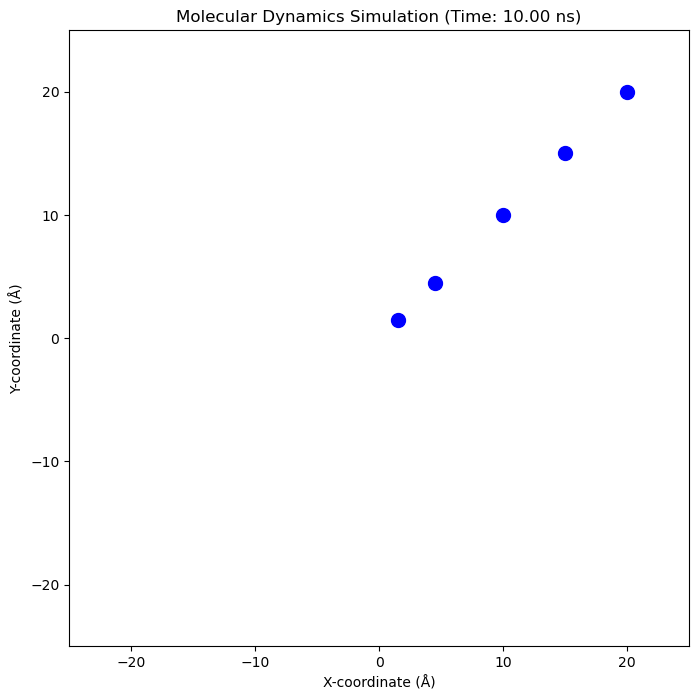

In [14]:
from __future__ import annotations
import numpy as np
from typing import List, Tuple, Optional, Set
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Atom:
    """Class representing an individual atom in the simulation."""
    def __init__(
        self, 
        position: Tuple[float, float, float], 
        velocity: Tuple[float, float, float], 
        mass: float, 
        epsilon: float, 
        sigma: float
    ) -> None:
        self.position: np.ndarray = np.array(position, dtype=float)  # 3D position vector
        self.velocity: np.ndarray = np.array(velocity, dtype=float)  # 3D velocity vector
        self.mass: float = mass
        self.epsilon: float = epsilon
        self.sigma: float = sigma
        self.force: np.ndarray = np.zeros(3, dtype=float)  # 3D force vector


class Potential(ABC):
    """Abstract base class for different potentials."""
    def __init__(self, pairwise_interactions: Optional[Set[Tuple[int, int]]] = None) -> None:
        """
        Args:
            pairwise_interactions: Optional set of (i, j) tuples specifying which atom pairs
                                   should interact. If None, all atom pairs interact.
                                   
            Note: here (i, j) is oriented, and if you want both (0,1) and (1,0) to be valid, 
                  you need to have both (0,1) and (1,0) in the set.
        """
        self.pairwise_interactions = pairwise_interactions  # Set of tuples (i, j)

    @abstractmethod
    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        """Compute forces acting on all atoms."""
        pass


class LennardJonesPotential(Potential):
    """A concrete class implementing the Lennard-Jones potential."""
    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        # Reset all forces
        for atom in atoms:
            atom.force.fill(0.0)

        num_atoms: int = len(atoms)
        for i in range(num_atoms):
            atom_i: Atom = atoms[i]
            for j in range(num_atoms):
                if i == j:  # Skip self-interaction
                    continue

                # 如果定义了特定的 pairwise_interactions，则判断 (i, j) 是否在其中
                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue

                atom_j: Atom = atoms[j]
                delta: np.ndarray = atom_i.position - atom_j.position
                # Apply minimum image convention for periodic boundaries
                delta -= box_size * np.round(delta / box_size)
                r: float = float(np.linalg.norm(delta))
                if r == 0:
                    continue
                epsilon_ij: float = np.sqrt(atom_i.epsilon * atom_j.epsilon)
                sigma_ij: float = (atom_i.sigma + atom_j.sigma) / 2
                F_mag: float = 4 * epsilon_ij * (
                    (12 * sigma_ij**12 / r**13) - (6 * sigma_ij**6 / r**7)
                )
                force_vector: np.ndarray = (F_mag / r) * delta
                atom_i.force += force_vector
                atom_j.force -= force_vector  # Newton's third law


class MolecularDynamicsSimulator:
    """Class for simulating molecular dynamics using a given Potential."""
    def __init__(
        self, 
        atoms: List[Atom], 
        box_size: float, 
        total_time: float, 
        total_steps: int,
        potential: Potential
    ) -> None:
        self.atoms = atoms
        self.box_size = box_size
        self.total_time = total_time
        self.total_steps = total_steps
        self.dt = total_time / total_steps
        self.num_atoms = len(atoms)
        self.positions = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.velocities = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.potential = potential  # Use the abstract Potential type

    def integrate(self) -> None:
        """Perform the Verlet integration to simulate molecular dynamics."""
        # Initialize positions and velocities
        for idx, atom in enumerate(self.atoms):
            self.positions[0, idx, :] = atom.position
            self.velocities[0, idx, :] = atom.velocity

        # Compute initial forces using the assigned potential
        self.potential.compute_forces(self.atoms, self.box_size)

        # Time integration loop
        for step in range(1, self.total_steps + 1):
            # Update positions
            for idx, atom in enumerate(self.atoms):
                atom.position += atom.velocity * self.dt + (atom.force / (2 * atom.mass)) * self.dt**2
                # Apply periodic boundary conditions
                atom.position %= self.box_size

            # Compute new forces
            self.potential.compute_forces(self.atoms, self.box_size)

            # Update velocities
            for idx, atom in enumerate(self.atoms):
                atom.velocity += (atom.force / atom.mass) * self.dt
                self.positions[step, idx, :] = atom.position
                self.velocities[step, idx, :] = atom.velocity

    def animate(
        self, 
        filename: str = 'md_simulation.gif', 
        interval: int = 50, 
        save_gif: bool = True
    ) -> None:
        """Create and optionally save an animation of the simulation."""
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(-self.box_size, self.box_size)
        ax.set_ylim(-self.box_size, self.box_size)
        ax.set_xlabel('X-coordinate (Å)')
        ax.set_ylabel('Y-coordinate (Å)')
        ax.set_title('Molecular Dynamics Simulation')

        def update(frame: int):
            ax.clear()
            ax.set_xlim(-self.box_size, self.box_size)
            ax.set_ylim(-self.box_size, self.box_size)
            ax.set_xlabel('X-coordinate (Å)')
            ax.set_ylabel('Y-coordinate (Å)')
            ax.set_title(f'Molecular Dynamics Simulation (Time: {frame * self.dt:.2f} ns)')
            pos = self.positions[frame]
            # 只显示 x,y 平面
            scat = ax.scatter(pos[:, 0], pos[:, 1], s=100, c='blue')
            return scat,

        ani = FuncAnimation(
            fig, 
            update, 
            frames=range(0, self.total_steps + 1, max(1, self.total_steps // 100)),  # 控制动画帧数，避免过慢
            interval=interval, 
            blit=True
        )

        if save_gif:
            ani.save(filename, writer='pillow', fps=20)
        plt.show()


if __name__ == "__main__":
    # Simulation parameters
    box_size: float = 25.0  # Units in Å
    total_time: float = 10.0  # Units in ns
    total_steps: int = 1000

    # Define initial positions and velocities of the atoms
    initial_positions = [
        (1.0, 1.0, 1.0),
        (5.0, 5.0, 1.0),
        (10.0, 10.0, 1.0),
        (15.0, 15.0, 1.0),
        (20.0, 20.0, 1.0)
    ]
    initial_velocities = [
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0),
        (0.0, 0.0, 0.0)
    ]
    mass: float = 1.0
    epsilon: float = 2.0
    sigma: float = 4.0

    atoms = [
        Atom(position=pos, velocity=vel, mass=mass, epsilon=epsilon, sigma=sigma)
        for pos, vel in zip(initial_positions, initial_velocities)
    ]

    # 例如，只让 (0,1) 和 (2,3) 这两对原子之间有 LJ 相互作用
    pairwise_interactions = {(0, 1), (1, 0)}

    # Create a Lennard-Jones potential with restricted interactions
    lj_potential = LennardJonesPotential(pairwise_interactions=pairwise_interactions)

    # Create the simulator
    simulator = MolecularDynamicsSimulator(atoms, box_size, total_time, total_steps, lj_potential)

    # Run simulation
    simulator.integrate()

    # Animate the results
    simulator.animate()
